In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [90]:
!python --version
print(torch.__version__)

Python 3.6.9
1.5.1+cu101


# Siamese Recurrent Architectures for Learning Sentence Similarity

(Mueller and Thyagarajan, 2016)

[![Man_LSTM](https://www.researchgate.net/profile/Zainab_Imtiaz2/publication/338786070/figure/fig1/AS:856942448742404@1581322409882/Siamese-Manhattan-LSTM-netowrk-with-zero-padding-for-max-sequence-length-20.png)](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FSiamese-Manhattan-LSTM-netowrk-with-zero-padding-for-max-sequence-length-20_fig1_338786070&psig=AOvVaw3SZ6t8pqGblLlb5BAdF6zD&ust=1594765945082000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCLiAx6Gky-oCFQAAAAAdAAAAABAD)

## Project Folder Structure
/data: Folder for all data

## Section 0: Setup 

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import torchtext
from torchtext import data
import spacy
import matplotlib.pyplot as plt


torch.manual_seed(1)
torch.backends.cuda.deterministic = True

## Section I: Exploratory Data Analysis

In [92]:
## Read in dataset
sickdata = pd.read_csv("/content/drive/My Drive/Colab Notebooks/final project/data/SICK.csv", index_col="pair_ID", sep="\t")
sickdata.head(1)
sickdata.dropna(subset=['sentence_B'], inplace=True)
# sickdata['entailment_numeric'] = sickdata['entailment_label'].apply(score_to_numeric)

In [93]:
list(sickdata.columns.values)

['sentence_A',
 'sentence_B',
 'entailment_label',
 'relatedness_score',
 'entailment_AB',
 'entailment_BA',
 'sentence_A_original',
 'sentence_B_original',
 'sentence_A_dataset',
 'sentence_B_dataset',
 'SemEval_set']

### Retrieve train, validate, test data

In [94]:
train_data = sickdata[sickdata.SemEval_set == 'TRAIN']
print(f'No. train: {len(train_data)}')
val_data = sickdata[sickdata.SemEval_set == 'TRIAL']
print(f'No. validation: {len(val_data)}')
test_data = sickdata[sickdata.SemEval_set == 'TEST']
print(f'No. test: {len(test_data)}')

No. train: 4439
No. validation: 495
No. test: 4906


In [95]:
train_sentA, train_sentB = train_data.sentence_A, train_data.sentence_B
val_sentA, val_sentB = val_data.sentence_A, val_data.sentence_B
test_sentA, test_sentB = test_data.sentence_A, test_data.sentence_B

In [96]:
train_data.to_csv("/content/drive/My Drive/Colab Notebooks/final project/data/SICK_train.csv")
val_data.to_csv("/content/drive/My Drive/Colab Notebooks/final project/data/SICK_val.csv")
test_data.to_csv("/content/drive/My Drive/Colab Notebooks/final project/data/SICK_test.csv")

## Section II: Preprocessing

Use TorchText 

Download the pre-trained [Glove](https://nlp.stanford.edu/projects/glove/) word embedding.

In [97]:
TEXT1 = data.Field(sequential=True, tokenize="spacy", lower=True, include_lengths=True)
TEXT2 = data.Field(sequential=True, tokenize="spacy", lower=True, include_lengths=True)
SCORE = data.LabelField(dtype=torch.float, use_vocab=False)

In [98]:
from torchtext.data import TabularDataset

# Define fields
# Pass in None for the columns we don't use
datafields = [("pair_ID", None), ("sentence_A", TEXT1), ("sentence_B", TEXT2), ("entailment_label", None), ("relatedness_score", SCORE), 
                  ("entailment_AB", None), ("entailment_BA", None), ("sentence_A_original", None), ("sentence_B_original", None), 
                  ("sentence_A_dataset", None), ("sentence_B_dataset", None), ("SemEval_set", None)]

# skip_header: if csv has a header, ensure to pass this so it doesn't get processed as data
train, val, test = data.TabularDataset.splits(
    path = "/content/drive/My Drive/Colab Notebooks/final project/data",
    train="SICK_train.csv",
    validation="SICK_val.csv", 
    test = "SICK_test.csv",
    format = "csv",
    fields=datafields,
    skip_header = True
)

In [99]:
print(train[0]) # get an Example object, it bundles the attributes of a single data point together
print(train[0].__dict__.keys())
print(train[0].sentence_A) # tokenized sentence, but not be converted to integer yet
print(train[0].sentence_B) # tokenized sentence, but not be converted to integer yet
print(train[0].relatedness_score) # tokenized sentence, but not be converted to integer yet

dict_keys(['sentence_A', 'sentence_B', 'relatedness_score'])
['a', 'group', 'of', 'kids', 'is', 'playing', 'in', 'a', 'yard', 'and', 'an', 'old', 'man', 'is', 'standing', 'in', 'the', 'background']
['a', 'group', 'of', 'boys', 'in', 'a', 'yard', 'is', 'playing', 'and', 'a', 'man', 'is', 'standing', 'in', 'the', 'background']
4.5


In [100]:
from torchtext import vocab
# build vocabulary on training set, limited to MAX_VOCAB_SIZE, and import glove as pretrained word embedding
MAX_VOCAB_SIZE = 25_000
vec = vocab.Vectors('/content/drive/My Drive/Colab Notebooks/final project/data/glove.6B/glove.6B.300d.txt', cache="./")
TEXT1.build_vocab(train, max_size=MAX_VOCAB_SIZE, vectors = vec)
TEXT2.build_vocab(train, max_size=MAX_VOCAB_SIZE, vectors = vec)
print(f"Unique tokens in Sentence 1 vocabulary: {len(TEXT1.vocab)}")
print(f"Unique tokens in Sentence 2 vocabulary: {len(TEXT2.vocab)}")
# print(TEXT.vocab.stoi)

Unique tokens in Sentence 1 vocabulary: 1957
Unique tokens in Sentence 2 vocabulary: 1909


In [101]:
# view the most common words in the vocabulary and their frequencies
print(TEXT1.vocab.freqs.most_common(20))

[('a', 6220), ('is', 4079), ('the', 2351), ('man', 1271), ('in', 1144), ('and', 1018), ('are', 861), ('on', 857), ('woman', 641), ('of', 593), ('dog', 551), ('playing', 537), ('with', 500), ('two', 354), ('no', 275), ('by', 272), ('an', 255), ('there', 255), ('person', 247), ('boy', 247)]


In [102]:
# view the vocabulary directly using the stoi (string to integer)
print(TEXT1.vocab.itos[:10])

['<unk>', '<pad>', 'a', 'is', 'the', 'man', 'in', 'and', 'are', 'on']


In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, val, test), 
    batch_size = 64, 
    sort_key = lambda x: x.sentence_A, 
    device = device
)

cuda


In [104]:
for batch in train_iterator:
  text_a, text_length = batch.sentence_A
  # print(text_a.shape)

In [105]:
class Manhattan_LSTM(nn.Module):
  def __init__(self, vocab_size_a, vocab_size_b, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx_a, pad_idx_b):
    super(Manhattan_LSTM, self).__init__()
    
    # transform our sparse one-hot vector into dense embedding vector, it's simply a FC layer
    self.embedding_a = nn.Embedding(vocab_size_a, embedding_dim, padding_idx=pad_idx_a)
    self.embedding_b = nn.Embedding(vocab_size_b, embedding_dim, padding_idx=pad_idx_b)
    
    self.lstm_a = nn.LSTM(embedding_dim, 
                          hidden_dim,
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout = dropout
                          ) 
    self.lstm_b = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout = dropout
                          ) 
    self.dropout = nn.Dropout(dropout)
        
  def exp_neg_manhattan_dist(self, x1, x2):
        """
        Function for the similarity estimate of the LSTMs outputs 
        g(h_a, h_b) = exp(-||h_a-h_b||_1)

        output: 
          shape: [batch size, 1]
        """
        # print(f"exp {torch.exp(-torch.sum(torch.abs(x1 - x2), dim=1))}")

        return torch.exp(-torch.sum(torch.abs(x1 - x2), dim=1))

  def forward(self, text_a, text_b, text_lengths):
        '''
        It is called when we feed exampples into our model

        input           -> (2 x Max. Sequence Length (per batch) x Batch Size)
        hidden          -> (2 x Num. Layers * Num. Directions x Batch Size x Hidden Size)
        '''
        # text: [sent len for that batch,  batch size]
        # embedded: [sent len, batch size, emb dim]
        embedded_1 = self.dropout(self.embedding_a(text_a))
        embedded_2 = self.dropout(self.embedding_b(text_b)) 

        outputs_1, (hidden_1, cell_1) = self.lstm_a(embedded_1)
        outputs_2, (hidden_2, cell_2) = self.lstm_b(embedded_2)

        # packed_embedded_1 = nn.utils.rnn.pack_padded_sequence(embedded_1, text_lengths, enforce_sorted=False)
        # packed_embedded_2 = nn.utils.rnn.pack_padded_sequence(embedded_2, text_lengths, enforce_sorted=False)
        
        # # output: [seq length, batch, num_directions*hidden_size]
        # # hidden state: [n_layers, batch size, hidden dim]
        # # cell state: [n_layers, batch size, hidden dim]
        # packed_outputs_1, (hidden_1, cell_1) = self.lstm_a(packed_embedded_1)
        # packed_outputs_2, (hidden_2, cell_2) = self.lstm_b(packed_embedded_2)

        # output1, output1_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs_1)
        # output2, output2_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs_2)
        # print(f"len: {output1.shape}")
        batch_size = text_a.shape[1]
        
        # first convert to shape [batch size, hidden dim, 2], then to shape [batch size, hidden dim * 2]
        # compute Manhattan distance
        similarity_scores = self.exp_neg_manhattan_dist(hidden_1.permute(1, 2, 0).reshape(batch_size, -1),
                                                                 hidden_2.permute(1, 2, 0).reshape(batch_size, -1))
        # print(f"hidden2 {hidden_1.permute(1, 2, 0).reshape(batch_size, -1).shape}")
        # print(f"sim score {similarity_scores}")
        
        # Multiply by 5, since exp_neg_manhattan_dist in [0,1], and similarity_score in [1, 5]
        return similarity_scores*5.0

In [106]:
input_dim_a = len(TEXT1.vocab)
input_dim_b = len(TEXT2.vocab)
embedding_dim = 300
hidden_dim = 50
output_dim = 1
n_layers = 2
bidirectional = False
dropout = 0.75
pad_idx_a = TEXT1.vocab.stoi[TEXT1.pad_token]
pad_idx_b = TEXT2.vocab.stoi[TEXT2.pad_token]


model = Manhattan_LSTM(input_dim_a, input_dim_b, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx_a, pad_idx_b)
model.to(device)

Manhattan_LSTM(
  (embedding_a): Embedding(1957, 300, padding_idx=1)
  (embedding_b): Embedding(1909, 300, padding_idx=1)
  (lstm_a): LSTM(300, 50, num_layers=2, dropout=0.75)
  (lstm_b): LSTM(300, 50, num_layers=2, dropout=0.75)
  (dropout): Dropout(p=0.75, inplace=False)
)

In [107]:
pretrained_embeddings_a = TEXT1.vocab.vectors
pretrained_embeddings_b = TEXT2.vocab.vectors
print(pretrained_embeddings_a.shape)

torch.Size([1957, 300])


In [108]:
model.embedding_a.weight.data.copy_(pretrained_embeddings_a)
model.embedding_b.weight.data.copy_(pretrained_embeddings_b)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2971,  0.0940, -0.0967,  ...,  0.0597, -0.2285,  0.2960],
        ...,
        [ 0.2059,  0.8033, -0.4308,  ..., -0.6662, -0.1958,  0.1413],
        [-0.4304, -0.4062, -0.1828,  ...,  0.0287, -0.4212,  0.2785],
        [-0.2284,  0.0568, -0.0209,  ...,  0.2419, -0.0964,  0.1198]],
       device='cuda:0')

In [109]:
UNK_IDX_a = TEXT1.vocab.stoi[TEXT1.unk_token]
model.embedding_a.weight.data[UNK_IDX_a] = torch.zeros(embedding_dim)
model.embedding_a.weight.data[pad_idx_a] = torch.zeros(embedding_dim)

UNK_IDX_b = TEXT2.vocab.stoi[TEXT2.unk_token]
model.embedding_b.weight.data[UNK_IDX_b] = torch.zeros(embedding_dim)
model.embedding_b.weight.data[pad_idx_b] = torch.zeros(embedding_dim)

print(model.embedding_a.weight.data)

print(model.embedding_b.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2971,  0.0940, -0.0967,  ...,  0.0597, -0.2285,  0.2960],
        ...,
        [ 0.1985,  0.9851,  0.6101,  ...,  0.2474, -0.2343, -0.5220],
        [ 0.1914,  0.0440,  0.1607,  ...,  0.4088,  0.2412,  0.2995],
        [-0.2843,  0.0480, -0.1506,  ..., -0.0901,  0.0169,  0.2928]],
       device='cuda:0')
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2971,  0.0940, -0.0967,  ...,  0.0597, -0.2285,  0.2960],
        ...,
        [ 0.2059,  0.8033, -0.4308,  ..., -0.6662, -0.1958,  0.1413],
        [-0.4304, -0.4062, -0.1828,  ...,  0.0287, -0.4212,  0.2785],
        [-0.2284,  0.0568, -0.0209,  ...,  0.2419, -0.0964,  0.1198]],
       device='cuda:0')


In [110]:
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_params(model)}: trainable parameters')

The model has 1341400: trainable parameters


In [111]:
def accuracy(preds, y, threshold): 
  overall_diff = torch.abs(preds-y)
  # print(f"overall before: {overall_diff}")
  overall_diff = torch.lt(overall_diff, threshold) # assign null to wrong prediction
  total = torch.sum(overall_diff)
  return total.item()/len(preds)

In [112]:
def train(model, iterator, optimizer, criterion, threshold):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for batch in iterator: 
    optimizer.zero_grad()
    text_a, text_lengths = batch.sentence_A
    text_b, text_lengths = batch.sentence_B
    pred = model(text_a, text_b, text_lengths)
    loss = criterion(pred, batch.relatedness_score)
    acc = accuracy(pred, batch.relatedness_score, threshold)
    # print(f"acc: {acc}")
    loss.backward()
    clipping_value = 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
    optimizer.step()

    epoch_loss += loss.item() # to get a Python num from a tensor of a single value
    epoch_acc += acc
    # print(f"total acc: {epoch_acc}")
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [113]:
def validation(model, iterator, criterion, threshold):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for batch in iterator: 
      text_a, text_lengths = batch.sentence_A
      text_b, text_lengths = batch.sentence_B
      pred = model(text_a, text_b, text_lengths)
      loss = criterion(pred, batch.relatedness_score)
      acc = accuracy(pred, batch.relatedness_score, threshold)

      epoch_loss += loss.item()
      epoch_acc += acc
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [114]:
import time
import numpy as np

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  return elapsed_time

In [115]:
class EarlyStopping():
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)
es = EarlyStopping(mode='max', patience=30)


In [116]:
import torch.optim as optim


N_EPOCHS = 50
best_valid_loss = float('inf')
train_loss_lst, train_acc_lst = [], []
validation_loss_lst, validation_acc_lst = [], []
lr = 0.01

optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 0.01)
criterion = nn.MSELoss()
criterion = criterion.to(device)

for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, threshold)
  train_loss_lst.append(train_loss)
  
  valid_loss, valid_acc = validation(model, valid_iterator, criterion, threshold)
  # if es.step(valid_acc):
  #       print("Early stopping!")
  #       break  # early stop criterion is met, we can stop now
  validation_loss_lst.append(valid_loss)
  
  end_time = time.time()

  elapsed_time = epoch_time(start_time, end_time)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_ManLSTM_model2.pt')

  print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_time} sec')
  print(f'\tTrain Loss: {train_loss: .3f} | Valid Loss: {valid_loss: .3f} ')

Epoch: 01 | Epoch Time: 0.771942138671875 sec
	Train Loss:  2.467 | Valid Loss:  1.213 
Epoch: 02 | Epoch Time: 0.7621743679046631 sec
	Train Loss:  1.384 | Valid Loss:  1.213 
Epoch: 03 | Epoch Time: 0.7489235401153564 sec
	Train Loss:  1.286 | Valid Loss:  2.170 
Epoch: 04 | Epoch Time: 0.7493207454681396 sec
	Train Loss:  1.438 | Valid Loss:  1.016 
Epoch: 05 | Epoch Time: 0.7587060928344727 sec
	Train Loss:  1.345 | Valid Loss:  1.021 
Epoch: 06 | Epoch Time: 0.7378940582275391 sec
	Train Loss:  1.380 | Valid Loss:  1.106 
Epoch: 07 | Epoch Time: 0.7540798187255859 sec
	Train Loss:  1.315 | Valid Loss:  1.125 
Epoch: 08 | Epoch Time: 0.7503836154937744 sec
	Train Loss:  1.382 | Valid Loss:  1.039 
Epoch: 09 | Epoch Time: 0.7574162483215332 sec
	Train Loss:  1.381 | Valid Loss:  2.182 
Epoch: 10 | Epoch Time: 0.7626924514770508 sec
	Train Loss:  1.346 | Valid Loss:  1.007 
Epoch: 11 | Epoch Time: 0.7370352745056152 sec
	Train Loss:  1.306 | Valid Loss:  1.696 
Epoch: 12 | Epoch Time

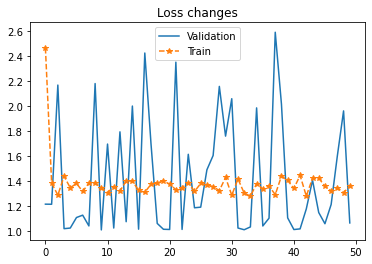

In [118]:
plt.plot(validation_loss_lst)
plt.plot(train_loss_lst, "*--")
plt.title("Loss changes")
plt.legend(["Validation", "Train"])

In [120]:
model.load_state_dict(torch.load('best_ManLSTM_model2.pt'))
test_loss, test_acc = validation(model, test_iterator, criterion, threshold)
print(f"Test Loss: {test_loss:.3f}")

Test Loss: 1.020
